In [526]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
seeed = 180

In [527]:
import os

# Customised for Windows setup
# os.chdir('SharedFiles/MAST30034-Group-Project/')

In [528]:
# Customised for Mac/Linux setup
raw_data = pd.read_csv("kaggle_bee_vs_wasp/labels.csv")
raw_data['path'] = raw_data['path'].str.replace("\\", "/")

By removing the low quality photos, we get rid of the is_other instances

In [529]:
high_quality_entries = raw_data[raw_data["photo_quality"] == 1]
high_quality_entries =high_quality_entries[high_quality_entries["label"] != "insect"]

In [530]:
print(high_quality_entries.shape)
high_quality_entries.head()

(4596, 10)


,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [531]:
[_,label_num] = np.unique(high_quality_entries["label"].values, return_inverse = True)
high_quality_entries.insert(loc = 0, column = "label_num", value = label_num)

In [532]:
# no non-insects found in the dataset
list(high_quality_entries["is_other"]).count(1)

0

In [533]:
3 in list(high_quality_entries["label_num"].values)

False

In [534]:
#taking a random sample for faster training time
# high_quality_entries = high_quality_entries.sample(1000)

In [535]:
images_path = high_quality_entries["path"].values.reshape(-1, 1)
labels = high_quality_entries["label"].values.reshape(-1, 1)

# Data

In [536]:
from matplotlib.image import imread

In [537]:
images = []

# random_sample = high_quality_entries.sample(10)
# Train 50 for now just to get the code running
for image_path in images_path:
    #image_path = image_path.replace("\\", "/")
    images.append(imread(os.path.join("kaggle_bee_vs_wasp", image_path[0])))

In [538]:
#If you need to check the images.

#imread outputs integers between 0-255

#images[0]
# f,ax = plt.subplots(3,3)
# for i in range(3):
#     for j in range(3):
#         ax[i,j].imshow(images[i+3*j])

## Resize

In [539]:
from skimage.transform import resize

In [540]:
#remove these images
images_to_remove_indecies = []

# resize images to 224 x 224 
for im in range(len(images)):
    images[im] = resize(images[im], (224,224))
    if images[im].shape != (224,224,3):
        print(im)
        images_to_remove_indecies.append(im)

#remove the anomalous images
for index in images_to_remove_indecies:
    print(index)

#remove the labels of the anomalous images
labels = np.delete(labels, images_to_remove_indecies)

1667
4033
4595
1667
4033
4595


In [541]:
del images[4595]
del images[4033]
del images[1667]

## Remove 1 image, manually change another

The images are supposed to have 3 channels - RGB

There are 2 anomalous images.
Image 2538 ('wasp1/50988238_1c313384d9_n.jpg') is black and white (1-channel)

Image 4163 ('bee1/509769820_83fa0a3ea9_n.jpg') has an extra channel for transparency, which can be removed.

In [542]:
# f, ax = plt.subplots(1,3)

# # left: Original
# ax[0].imshow(images[1667])

# # middle: Transparency removed, still the same
# ax[1].imshow(images[4033])

# # right: This is how the original looks like in the file.
# # I had to subtract and add greys to reproduce it here for convenience.
# ax[2].imshow(images[4595])

In [543]:
# #remove the alpha channel
# images[1667] = images[1667][:,:,0:3]
    
# # Delete the black and white one,
# del images[4595]
# del images[4033]

# plt.imshow(images[1667])
# label_deleted = np.delete(labels, [4033, 4595])

# print('number of images in data:', len(images), len(label_deleted))


## Encoding the image labels

In [544]:
from sklearn.preprocessing import LabelEncoder

In [545]:
# Encode as integers
encoder = LabelEncoder()
transformed_label = encoder.fit_transform(np.ravel(labels))

print('number of labels:', len(transformed_label))

number of labels: 4593


In [546]:
np.unique(transformed_label, return_counts=True)

(array([0, 1]), array([2468, 2125]))

In [547]:
# OR baseline
print(max(np.unique(transformed_label, return_counts=True)[1])/len(transformed_label)) #35% is the baseline

0.537339429566732


# Data augmentation

Split a training set from a validation set first, to prevent data leakage.
Augment a training set.

https://stats.stackexchange.com/questions/175504/how-to-do-data-augmentation-and-train-validate-split

In [548]:
image_array = np.array(images)
image_array.shape

(4593, 224, 224, 3)

In [549]:
#Train/validation/test split
from sklearn.model_selection import train_test_split

# 15% in test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(image_array, transformed_label, 
                                              test_size = 0.15, random_state = seeed, 
                                              stratify = transformed_label)

# of 70%, 20% in validation
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, 
                                              test_size = 0.18, random_state = seeed, 
                                              stratify = Ytrain)

#70% training, 15% validation, 15% in test

print(Xtrain.shape, Ytrain.shape)
print(Xval.shape, Yval.shape)
print(Xtest.shape, Ytest.shape)

(3201, 224, 224, 3) (3201,)
(703, 224, 224, 3) (703,)
(689, 224, 224, 3) (689,)


In [550]:
# Augmented training data
train_generator = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    rotation_range=90,
    zoom_range=0.4,
    horizontal_flip=True,
    # vertical_flip==True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    channel_shift_range=0.3)

# No augmentation on validation
val_generator = keras.preprocessing.image.ImageDataGenerator()

train_generator.fit(Xtrain)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


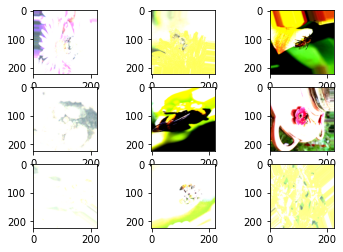

In [551]:
# If images need to be viewed, use batch size 1. Else keep batch size 32

augmented_train = train_generator.flow(Xtrain, Ytrain, batch_size=1)

for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = augmented_train.next()
    # convert to unsigned integers for viewing
    image = batch[0]
#     # plot raw pixel data
    image = np.reshape(image, (224,224,3))
    plt.imshow(image)

# Prepare for model

In [552]:
# images = np.array(images)
# inputs = keras.applications.resnet50.preprocess_input(images) 

# Model - MobileNetV2 (baseline)

3692 images in a training set. Augmented images will be generated from this set for training.

1231 unaugmented images will be used for validation.

In [553]:
# mbnet = keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet')
# avg = keras.layers.GlobalAveragePooling2D()(mbnet.output)
# #drop = keras.layers.Dropout(0.7)(avg)
# output = keras.layers.Dense(3, activation='softmax')(avg)

# m0 = keras.Model(inputs = mbnet.input, outputs = output)

# for layer in mbnet.layers:
#     layer.trainable = False

# optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)

# m0.compile(loss="sparse_categorical_crossentropy", 
#            optimizer=optimizer,
#            metrics=["accuracy"])

In [554]:
# h0 = m0.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
#             epochs=5, steps_per_epoch=20,
#             validation_data = val_generator.flow(Xval, Yval, batch_size=32),
#             validation_steps = int(len(Yval)/32))

# # Trains 3,200 images
# # Validates on len(Yval) (should be entire validation set)

In [555]:
# m0.evaluate(Xtest,Ytest)

In [556]:
# plt.plot(np.arange(0,len(h0.history['accuracy'])), h0.history['accuracy'])
# plt.plot(np.arange(0,len(h0.history['val_accuracy'])), h0.history['val_accuracy'])
# plt.legend(['training', 'validation'])

# plt.xticks(ticks=np.arange(0,len(h0.history['accuracy'])), 
#            labels=np.arange(0,len(h0.history['accuracy'])))
# plt.xlim(0,len(h0.history['accuracy']))
# plt.xlabel('Epochs (32*20=640 training examples per epoch)')
# plt.title('Model Accuracy')

In [557]:
# plt.plot(np.arange(0,len(h0.history['loss'])), h0.history['loss'])
# plt.plot(np.arange(0,len(h0.history['val_loss'])), h0.history['val_loss'])
# plt.legend(['training', 'validation'])

# plt.xticks(ticks=np.arange(0,len(h0.history['loss'])), 
#            labels=np.arange(0,len(h0.history['loss'])))
# plt.xlim(0,len(h0.history['accuracy']))
# plt.xlabel('Epochs (32*20=640 training examples per epoch)')
# plt.title('Model Loss')

In [558]:
# Final (15 epochs): 84-86% in training, 80-86% in validation

# Model Design

Speeding up training:
* Batch normalisation, Adam optimisation

Design options
* Convolution: Window size, Stride
* Activation functions: Softmax, ReLU
* Pooling: Average, Max
* Dense layer - fully connected.

Regularisation options
* Dropout: for regularisation

Other options
* Residual block (resnet)
* Batch normalisation: makes models faster and more stable.

Design recommendations
* Multiple 3x3 convolutions are preferred. (https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15, VGGNet?)
* Downsample by using pooling to reduce spatial information
* Common paradigm is to use max pooling in the network, and average pooling at the end, before the last dense layer
* Depth tends to result in higher accuracy

After all this, try to augment the data:
* rotations
* flips
* slight colour changes (for lighting conditions)

In [559]:
       
# Filter: number of filters to learn - to be specified
# kernel_size: height and width of filter - to be specified
# Strides = (1,1) by default (no skip).
# Padding (if a filter doesn't fit)
# Activation = 'relu' (applied after calculations)
# Bias = True by default

# Consider regularisers after
# m1.add(keras.layers.BatchNormalization())
# m1.add(keras.layers.Dropout(0.5))
# m1.add(keras.layers.Activation("relu"))
# m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
# m1.add(keras.layers.GlobalAvgPool2D())
# m1.add(keras.layers.Flatten())
# m1.add(keras.layers.Dense(10, activation="softmax"))


## Original Model

In [568]:
m1 = keras.models.Sequential()

m1.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding='same'))
m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
m1.add(keras.layers.BatchNormalization())

m1.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding='same'))
m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
m1.add(keras.layers.BatchNormalization())


m1.add(keras.layers.Flatten())
m1.add(keras.layers.Dense(10, activation="relu"))
# m1.add(keras.layers.GlobalAveragePooling2D())
m1.add(keras.layers.BatchNormalization())
m1.add(keras.layers.Dense(3, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)
#optimizer = keras.optimizers.Adam()

m1.compile(loss="sparse_categorical_crossentropy",
           optimizer=optimizer,
           metrics=["accuracy"])
           
           #, keras.metrics.Precision()])


In [569]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.05)

h1 = m1.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
            epochs=23, steps_per_epoch=20,
            validation_data = (Xval, Yval),
            callbacks=[callback])

# 32*20 = 640 examples per epoch
# 15,000/640 = 23 epochs to cycle over the original size * 3

Epoch 1/23
20/20 [==============================] - 34s 2s/step - loss: 0.9171 - accuracy: 0.5703 - val_loss: 11.9089 - val_accuracy: 0.5377
Epoch 2/23
20/20 [==============================] - 32s 2s/step - loss: 0.7778 - accuracy: 0.5297 - val_loss: 0.9672 - val_accuracy: 0.5789
Epoch 3/23
20/20 [==============================] - 32s 2s/step - loss: 0.6461 - accuracy: 0.6375 - val_loss: 0.8400 - val_accuracy: 0.5932
Epoch 4/23
20/20 [==============================] - 32s 2s/step - loss: 0.5743 - accuracy: 0.7063 - val_loss: 0.7436 - val_accuracy: 0.5974
Epoch 5/23
20/20 [==============================] - 33s 2s/step - loss: 0.6053 - accuracy: 0.7109 - val_loss: 0.7042 - val_accuracy: 0.5889
Epoch 6/23
20/20 [==============================] - 31s 2s/step - loss: 0.5778 - accuracy: 0.6859 - val_loss: 0.6568 - val_accuracy: 0.6401
Epoch 7/23
20/20 [==============================] - 32s 2s/step - loss: 0.5614 - accuracy: 0.7109 - val_loss: 0.8345 - val_accuracy: 0.5277
Epoch 8/23
20/20 [=

# Assessment of model fit

Check for overfitting
Epoch vs. [Training accuracy, training loss, validation accuracy, validation loss]


To do: checkpointing on training. Want to be able to load a previous model and continue training


In [ ]:
h1.model.summary()


In [ ]:
# Doesnt work on university VM
# keras.utils.plot_model(m1, to_file='m1.png')

In [ ]:
plt.plot(np.arange(0,len(h1.history['accuracy'])), h1.history['accuracy'])
plt.plot(np.arange(0,len(h1.history['val_accuracy'])), h1.history['val_accuracy'])
plt.legend(['training', 'validation'])

plt.xticks(ticks=np.arange(0,len(h1.history['accuracy']),2), labels=np.arange(0,len(h1.history['accuracy']),2))
plt.xlim(0,len(h1.history['accuracy']))
plt.xlabel('Epochs (6400 training examples per epoch)')
plt.title('Model Accuracy')

In [ ]:
plt.plot(np.arange(0,len(h1.history['loss'])), h1.history['loss'])
plt.plot(np.arange(0,len(h1.history['val_loss'])), h1.history['val_loss'])
plt.legend(['training', 'validation'])

plt.xticks(ticks=np.arange(0,len(h1.history['accuracy']),2), 
           labels=np.arange(0,len(h1.history['accuracy']),2))
plt.xlim(0,len(h1.history['accuracy']))
plt.xlabel('Epochs (6400 training examples per epoch)')
plt.title('Loss')

https://stackoverflow.com/questions/55894132/how-to-correct-unstable-loss-and-accuracy-during-training-binary-classificatio

Dealing with validation instability.

Cause: possibly too sensitive to the batches, so that any learning is unlearned on the next batch.

Try increasing size (number of nodes in a layer, also depth).

Early stopping

In [432]:
m1.evaluate(Xtest, Ytest)

InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [32,3] and labels shape [4816896]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-432-d696a088fff1>:1) ]] [Op:__inference_test_function_10336]

Function call stack:
test_function


# M2

In [127]:
m2 = keras.models.Sequential()

m2.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding='same'))
m2.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
m2.add(keras.layers.BatchNormalization())

m2.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding='same'))
m2.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
m2.add(keras.layers.BatchNormalization())

m2.add(keras.layers.Flatten())
m2.add(keras.layers.Dense(10, activation="relu"))
m2.add(keras.layers.BatchNormalization())
m2.add(keras.layers.Dense(3, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)
#optimizer = keras.optimizers.Adam()

m2.compile(loss="sparse_categorical_crossentropy",
           optimizer=optimizer,
           metrics=['accuracy'])


In [434]:
def plot_model_metrics(hist):

    f, ax = plt.subplots(2,1)
    f.subplots_adjust(hspace=0.6)

    ax[0].plot(np.arange(0,len(hist.history['accuracy'])), hist.history['accuracy'])
    ax[0].plot(np.arange(0,len(hist.history['val_accuracy'])), hist.history['val_accuracy'])
    ax[0].legend(['training', 'validation'])

    ax[0].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))
    
    ax[0].set_xticklabels(labels=np.arange(0,len(hist.history['accuracy']),2))
    ax[0].set_xlim(0,len(hist.history['accuracy']))
    ax[0].set_xlabel('Epochs (32*20 = 640 training examples per epoch)')
    ax[0].set_title('Model Accuracy')

    ax[1].plot(np.arange(0,len(hist.history['loss'])), hist.history['loss'])
    ax[1].plot(np.arange(0,len(hist.history['val_loss'])), hist.history['val_loss'])
    ax[1].legend(['training', 'validation'])

    ax[1].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))
    ax[1].set_xticklabels(labels=np.arange(0,len(hist.history['accuracy']),2))
    ax[1].set_xlim(0,len(hist.history['accuracy']))
    ax[1].set_xlabel('Epochs (32*20 = 640 training examples per epoch)')
    ax[1].set_title('Loss')
    